In [1]:
import numpy as np
import sys
import tensorflow as tf
import os
from threading import Thread
from datetime import datetime
import cv2
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
from PIL import ImageFile
from matplotlib import image
import seaborn as sns
import keras

c:\Users\wamik\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


#### Extract hand

In [2]:
MODEL_NAME = '../../models_hand extraction'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(MODEL_NAME, 'hand_label_map.pbtxt')

NUM_CLASSES = 8

In [3]:
# -----------------------------------------------
# Hand Detection
# -----------------------------------------------
# download model and proto buf from hhttps://github.com/molyswu/hand_detection/tree/temp/hand_detection/protos

def load_inference_graph():

    # load frozen tensorflow model into memory
    print("> ====== loading HAND frozen graph into memory")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def = tf.compat.v1.GraphDef()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        sess = tf.compat.v1.Session(graph=detection_graph)
    print("> ======= Hand Inference graph loaded.")
    return detection_graph, sess


In [4]:
def detect_objects(image_np, detection_graph, sess):
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    image_np_expanded = np.expand_dims(image_np, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores,
            detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    return np.squeeze(boxes), np.squeeze(scores)

In [5]:
detection_graph, sess = load_inference_graph()

> ====== loading HAND frozen graph into memory
> ======= Hand Inference graph loaded.


In [6]:
def extractHand(ori_img, img_np, width, height): 
  hasHand = False
  boxes, scores = detect_objects(img_np, detection_graph, sess)
  # Create a blank white image with the same dimensions as the original image
  new_image = Image.new("RGB", (width, height), (255, 255, 255))

  for i, box in enumerate(boxes):
    # Get the box coordinates
    ymin, xmin, ymax, xmax = box
    ymin = int(ymin * img_np.shape[0])
    xmin = int(xmin * img_np.shape[1])
    ymax = int(ymax * img_np.shape[0])
    xmax = int(xmax * img_np.shape[1])
    if scores[i] > 0.4: 
      box_pixels = ori_img.crop((xmin, ymin, xmax, ymax))
      new_image.paste(box_pixels, (xmin, ymin))
      hasHand = True
  plt.imshow(new_image)
  plt.show()
  return new_image, hasHand
  

#### Extract face 

In [7]:
modelFile = "../../models_face extraction/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "../../models_face extraction/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [20]:
# -----------------------------------------------
# Face Detection using DNN Net
# -----------------------------------------------
# detect faces using a DNN model 
# download model and prototxt from https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison/models

def detectFaceOpenCVDnn(net, frame):
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, mean = [104, 117, 123])

    net.setInput(blob)
    detections = net.forward()
    conf_threshold = 0.1
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            conf_threshold = confidence
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            box = [x1, y1, x2, y2]

    if box == None:
        return []
    # extract the face
    # face_boundary = frame[box[1]:box[3], box[0]:box[2]]

    # resize pixels to the model size
    # face_image = Image.fromarray(face_boundary)
    # face_array = np.asarray(face_image)

    return box

In [34]:
def extractFace(image):
    hasFace = False
    img_re = cv2.resize(image, (640, 480))
    img_pil = Image.fromarray(img_re)
    frame = detectFaceOpenCVDnn(net, img_re)
    box_pixels = img_pil.crop((frame[0], frame[1], frame[2], frame[3]))
    extracted_face = np.array(box_pixels)
    plt.imshow(extracted_face)
    plt.show()
    if (np.array(extracted_face).any()):
        hasFace = True
    return extracted_face, hasFace

In [10]:
ORI_MODEL_PATH = '../models/distracted-inception_dropout_best.hdf5'
HAND_MODEL_PATH = '../models/best_model_hand_molyswu.h5'
FACE_MODEL_PATH = '../models/best_model_face_inception.h5'

In [11]:
ori_model = keras.models.load_model(ORI_MODEL_PATH, compile=False)
hand_model = keras.models.load_model(HAND_MODEL_PATH)
face_model = keras.models.load_model(FACE_MODEL_PATH)

In [12]:
# ensemble classifier

def weighted_probability(networks_outputs):
    best_weights = [0.830111236560315, 13.19270879604911, 80.64850022164245]
    num_of_classifiers = 3
    num_of_classes = 8
    result = [0 for i in range(0, num_of_classes)]
    sum = 0

    for i in range(0, num_of_classifiers):
        curr_network_output = networks_outputs[i]
        curr_weight = best_weights[i]

        for j in range(0, num_of_classes):
            result[j] += curr_network_output[j] * curr_weight
            sum += result[j]
    
    for k in range(0, num_of_classes): # Normalising to ensure that the final output is still in terms of probability
        result[k] = result[k] / sum

    return result

#### Predicting for individual images

In [35]:
def predict(img_path):
    # extract hand
    img = Image.open(img_path)
    img_np = np.array(img)
    width, height = img.size
    hand_img, hasHand = extractHand(img, img_np, width, height)
    # extract face
    img_orig = cv2.imread(img_path)
    face_img, hasFace = extractFace(img_orig)
    # predict
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    input_data = preprocess_input(img_array)
    y_orig_pred = ori_model.predict(input_data)

    if (hasHand and hasFace):
        img_resize = cv2.resize(face_img, (75, 100))
        img_array = np.asarray(img_resize)
        img_array = np.expand_dims(img_array, axis=0)
        input_data = img_array/255.0
        y_face_pred = face_model.predict(input_data)

        img_resize = hand_img.resize((75, 100))
        img_array = np.asarray(img_resize)
        img_array = np.expand_dims(img_array, axis=0)
        input_data = img_array/255.0
        y_hands_pred = hand_model.predict(input_data)

        networks_outputs = np.asarray([y_orig_pred[0], y_face_pred[0], y_hands_pred[0]])
        final_pred = np.argmax(weighted_probability(networks_outputs))
    else: 
        final_pred = np.argmax(y_orig_pred)
    print("Predicted class: ", final_pred)
  
  

#### Test

In [39]:
DATA_PATH = os.path.join(os.getcwd(), "../../Combined New")
TEST_PATH = os.path.join(DATA_PATH, "test")
img_path = os.path.join(TEST_PATH, 'c2', '1483875.jpg')
img_path_1 = os.path.join(TEST_PATH, 'c3', '05379.jpg')

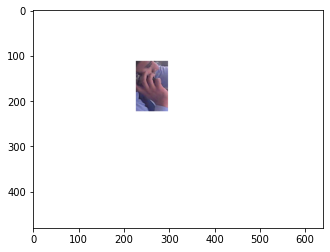

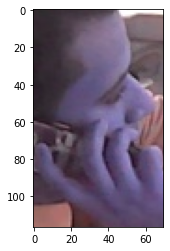

1/1 [==============================] - 0s 27ms/step
Predicted class:  2


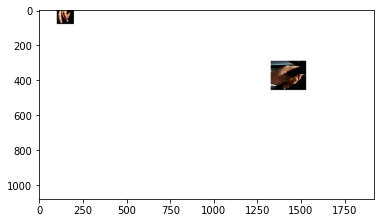

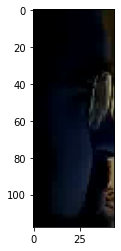

1/1 [==============================] - 0s 37ms/step
Predicted class:  3


In [40]:
predict(img_path)
predict(img_path_1)